Dependencies

In [ ]:
import random
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import RMSprop


Deck

In [ ]:
class Deck:
    def __init__(self):

        self.shuffle()

    def shuffle(self):
        cards = (np.arange(0,10) + 1)
        cards = np.repeat(cards,4*3) #4 suits x 3 decks
        np.random.shuffle(cards)
        self._cards = cards.tolist()

    def draw(self):
        return self._cards.pop()

Player for blackjack

In [ ]:
class Player:
    def __init__(self, strategy = None):
        self._hand = []
        self.strategy = strategy
        self._learning = False

    def get_hand(self):
        return self._hand

    def get_action(self, state = None):
        if self.strategy == "default":
            if self.get_hand_value() < 15:
                return 'hit'
            else:
                return 'stay'
        
        elif self.strategy == "random":
            return np.random.choice(['hit','stay'])

        elif self.strategy == "user":
            input = input("Hit or stay?")
            if input != "hit" or input != "stay":
                print("Invalid input")
                print("Valid actions are: hit, stay")
                return self.get_action(strategy = "user")


    def get_hand_value(self):
        return sum(self._hand)


    def hit(self, deck):
        card_value = deck.draw()
        self._hand.append(card_value)

    def stay(self):
        return True

    def reset_hand(self):
        self._hand = []

    def update(self, new_state, reward):
        pass

QLearner

In [ ]:
class Learner(Player):
    def __init__(self):
        super().__init__()
        self._Q = {}
        self._last_state = None
        self._last_action = None
        self._learning_rate = .7
        self._discount = .9
        self._epsilon = .9
        self._learning = True

    def reset_hand(self):
        self._hand = []
        self._last_state = None
        self._last_action = None

    def get_action(self, state):
        if state in self._Q and np.random.uniform(0,1) < self._epsilon:
            action = max(self._Q[state], key = self._Q[state].get)
        else:
            action = np.random.choice(['hit', 'stay'])
            if state not in self._Q:
                self._Q[state] = {}
            self._Q[state][action] = 0

        self._last_state = state
        self._last_action = action

        return action

    def update(self,new_state,reward):
        if self._learning:
            old = self._Q[self._last_state][self._last_action]

            if new_state in self._Q:
                new = self._discount * self._Q[new_state][max(self._Q[new_state], key=self._Q[new_state].get)]
            else:
                new = 0

            self._Q[self._last_state][self._last_action] = (1-self._learning_rate)*old + self._learning_rate*(reward+new)



DQNlearner

In [ ]:
class DQNLearner(Learner):
    def __init__(self):
        super().__init__()
        self._learning = True
        self._learning_rate = .1
        self._discount = .1
        self._epsilon = .9

        # Create Model
        model = Sequential()

        model.add(Dense(2, input_shape=(2,)))
        model.add(Activation('relu'))

        model.add(Dense(10))
        model.add(Activation('relu'))

        model.add(Dense(4))
        model.add(Activation('linear'))

        rms = RMSprop()
        model.compile(loss='mse', optimizer=rms)

        self._model = model


    def get_action(self, state):
        rewards = self._model.predict([np.array([state])], batch_size=1, verbose=0)

        if np.random.uniform(0,1) < self._epsilon:
            if rewards[0][0] > rewards[0][1]:
                action = 'hit'
            else:
                action = 'stay'
        else:
            action = np.random.choice(['hit', 'stay'])

        self._last_state = state
        self._last_action = action
        self._last_target = rewards


        return action

    def update(self,new_state,reward):
        if self._last_target[0][0] > 0.9 and self._last_target[0][1] > 0.9:
                self._learning = False
        if self._learning:
            rewards = self._model.predict([np.array([new_state])], batch_size=1, verbose=0)
            maxQ = rewards[0][0] if rewards[0][0] > rewards[0][1] else rewards[0][1]
            new = self._discount * maxQ

            if self._last_action == 'hit':
                self._last_target[0][0] = reward+new
            else:
                self._last_target[0][1] = reward+new

            # Update model
            self._model.fit(np.array([self._last_state]), self._last_target, batch_size=1, epochs=1, verbose=0)
        


blackjack game to be played

In [ ]:
class Game:
    def __init__(self, players = None):
        self.p1 = players[0]
        self.p2 = players[1]

    def run(self, num_games = 1000, train = True):
        results = [[], [], []]
        for i in tqdm(range(num_games)):
            d, winner = self.reset_round()

            state = self.get_state(self.p1, self.p2)

            while True:
                p1_action = self.p1.get_action(state)
                p2_action = self.p2.get_action(state)

                if p1_action == 'hit':
                    self.p1.hit(d)
                
                if p2_action == 'hit':
                    self.p2.hit(d)

                if self.determine_if_bust(self.p1):
                    winner = 'player2'
                    break

                elif self.determine_if_bust(self.p2):
                    winner = 'player1'
                    break

                if p1_action == p2_action and p1_action == 'stay':
                    break

                state = self.get_state(self.p1, self.p2)
            
            state = self.get_state(self.p1, self.p2)
            
            if winner is None:
                winner = self.determine_winner(self.p1, self.p2)

            if winner == 'player1':
                results[0].append(1)
                results[1].append(0)
                results[2].append(0)
            elif winner == 'player2':
                results[0].append(0)
                results[1].append(1)
                results[2].append(0)
            elif winner == 'tie':
                results[0].append(0)
                results[1].append(0)
                results[2].append(1)
            
        
            #class of player1, class of player2 is dqn update
            if train:
                if winner == 'player1':
                    self.p1.update(state, 1)
                    self.p2.update(state, -1)
                elif winner == 'player2':
                    self.p1.update(state, -1)
                    self.p2.update(state, 1)
                elif winner == 'tie':
                    self.p1.update(state, 0)
                    self.p2.update(state, 0)
                if self.p1._learning == False:
                    break

        return self.p1, self.p2, results


           

    def get_state(self, player1, player2):
        return (player1.get_hand_value(), player2.get_hand_value())

    def determine_winner(self,player1,player2):
        if player1.get_hand_value() > player2.get_hand_value():
            return 'player1'
        elif player1.get_hand_value() < player2.get_hand_value():
            return 'player2'
        elif player1.get_hand_value() == player2.get_hand_value():
            return 'tie'

    def determine_if_bust(self, player):
        if player.get_hand_value() > 21:
            return True
        else:
            return False

    def reset_round(self):
        d = Deck()

        self.p1.reset_hand()
        self.p2.reset_hand()
        
        winner = None
        self.p1.hit(d)
        self.p2.hit(d)
        self.p1.hit(d)
        self.p2.hit(d)
        
        return d, winner

In [ ]:
#train dqn
p1 = DQNLearner()
p2 = Player(strategy = 'default')

g = Game(players = [p1, p2])
p1, p2, results = g.run(num_games = 50000, train = True)

print(results)

100%|██████████| 50000/50000 [3:22:22<00:00,  4.12it/s]

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,

Player 1 wins:  11996
Player 2 wins:  34783
Ties:  3221


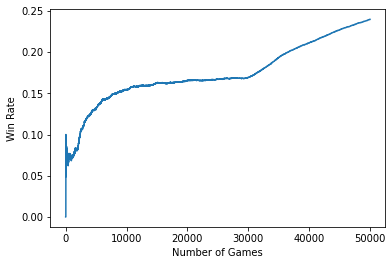

In [ ]:
print('Player 1 wins: ', sum(results[0]))
print('Player 2 wins: ', sum(results[1]))
print('Ties: ', sum(results[2]))

#find player 1 win rate over time
winrate = []
for i in range(1, len(results[0])+1):
    winrate.append(sum(results[0][:i])/i)

#add labels
plt.xlabel('Number of Games')
plt.ylabel('Win Rate')
plt.plot(winrate)
plt.savefig('plot1.png')

Test Models

In [ ]:
#set seed
random.seed(1)

100%|██████████| 200/200 [00:30<00:00,  6.56it/s]

[[1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0], [0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 

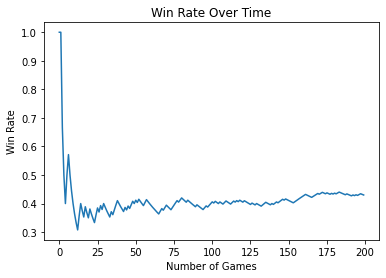

In [ ]:
#test dqn
t1 = p1
t2 = Player(strategy = 'default')
g1 = Game(players = [t1, t2])
t1, t2, results1 = g1.run(num_games = 200, train = False)
print(results1)

print('Player 1 wins: ', sum(results1[0]))
print('Player 2 wins: ', sum(results1[1]))
print('Ties: ', sum(results1[2]))

#find player 1 win rate over time
winrate1 = []
for i in range(1, len(results1[0])+1):
    winrate1.append(sum(results1[0][:i])/i)

#add labels
plt.xlabel('Number of Games')
plt.ylabel('Win Rate')
plt.title('Win Rate Over Time')
plt.plot(winrate1)


100%|██████████| 200/200 [00:00<00:00, 12166.22it/s]


[[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0], [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 

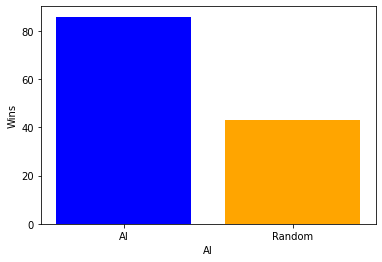

In [ ]:
#one 100 round simulation random vs default

t1 = Player(strategy = 'random')
t2 = Player(strategy = 'default')
players = [t1, t2]
g2 = Game(players = players)
t1, t2, results2 = g2.run(num_games = 200, train = False)
print(results2)


print('Player 1 wins: ', sum(results2[0]))
print('Player 2 wins: ', sum(results2[1]))
print('Ties: ', sum(results2[2]))

#find player 1 win rate over time
winrate2 = []
for i in range(1, len(results2[0])+1):
    winrate2.append(sum(results2[0][:i])/i)

#add labels
plt.xlabel('Number of Games')
plt.ylabel('Win Rate')
plt.plot(winrate1, label = "DQN")
plt.plot(winrate2, label = "Random")
plt.legend()


plt.savefig('plot2.png')

x_axis = ['AI', 'Random']
y_axis = [sum(results1[0]), sum(results2[0])]

plt.close()

plt.bar(x_axis, y_axis, color=['blue', 'orange'])
plt.xlabel("AI")
plt.ylabel("Wins")
plt.savefig('plot5.png')

100%|██████████| 200/200 [00:19<00:00, 10.11it/s]


[[1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 

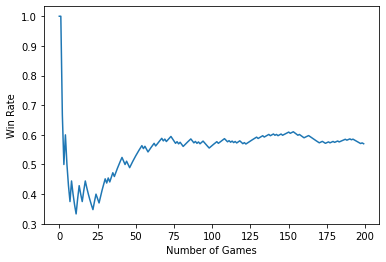

In [ ]:
#one 100 round simulation random vs default

t1 = p1
t2 = Player(strategy = 'random')
players = [t1, t2]
g2 = Game(players = players)
t1, t2, results2 = g2.run(num_games = 200, train = False)
print(results2)


print('Player 1 wins: ', sum(results2[0]))
print('Player 2 wins: ', sum(results2[1]))
print('Ties: ', sum(results2[2]))

#find player 1 win rate over time
winrate2 = []
for i in range(1, len(results2[0])+1):
    winrate2.append(sum(results2[0][:i])/i)

#add labels
plt.xlabel('Number of Games')
plt.ylabel('Win Rate')
plt.plot(winrate2)

plt.savefig('plot3.png')


100%|██████████| 200/200 [00:24<00:00,  8.20it/s]


[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 

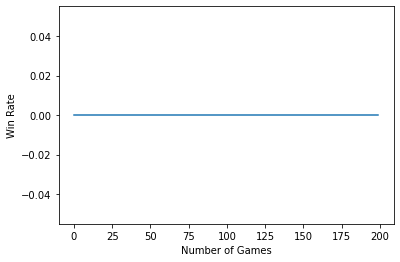

In [ ]:
#one 100 round simulation random vs default

t1 = p1
t2 = t1
players = [t1, t2]
g2 = Game(players = players)
t1, t2, results2 = g2.run(num_games = 200, train = False)
print(results2)


print('Player 1 wins: ', sum(results2[0]))
print('Player 2 wins: ', sum(results2[1]))
print('Ties: ', sum(results[2]))

#find player 1 win rate over time
winrate2 = []
for i in range(1, len(results2[0])+1):
    winrate2.append(sum(results2[0][:i])/i)

#add labels
plt.xlabel('Number of Games')
plt.ylabel('Win Rate')
plt.plot(winrate2)

plt.savefig('plot4.png')